### Cross-modal prediction

This notebook demonstrates how to use a pre-trained model to perform cross-modal prediction for the Patch-seq gene expression and electrophysiology data.

#### 1. Load pre-trained model

In [1]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

In [4]:
import tensorflow as tf
import numpy as np
from utils.dataset import load_bioarxiv_dataset,partitions
from model import Model_TE_aug_decoders, custom_build

In [5]:
n_partitions=40
cvfold=0

D = load_bioarxiv_dataset('../data/proc/')
XT = D['T_dat']
XE = D['E_pcipfx']
XE[np.isnan(XE)] = 0.0

ind_dict = partitions(D['cluster'], n_partitions=40, seed=0)
train_ind,val_ind = ind_dict[cvfold]['train'],ind_dict[cvfold]['val']

T_dim = XT.shape[1]
E_dim = XE.shape[1]

In [6]:
#Load and build model
cplAE = Model_TE_aug_decoders(T_dim,E_dim)
cplAE = custom_build(cplAE,(T_dim,E_dim))

#Load pre-trained network weights
cplAE.load_weights('../data/pretrained_models/cplAE_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0-weights.h5')

#### 2. Obtain reconstructions and cross-modal predictions
Within modality reconstructions: 
 - $X_{t}\rightarrow z_{t}\rightarrow \widetilde{X}_t$
 - $X_{e}\rightarrow z_{e}\rightarrow \widetilde{X}_e$

Cross-modal predictions:
 - $X_{t}\rightarrow z_{t}\rightarrow \widetilde{X}_e$
 - $X_{e}\rightarrow z_{e}\rightarrow \widetilde{X}_t$

In [7]:
#Use only the pre-trained encoders to get representation
zT = cplAE.encoder_T(tf.constant(XT,dtype=tf.float32),training=False)
zE = cplAE.encoder_E(tf.constant(XE,dtype=tf.float32),training=False)

#Use pre-trained decoders to obtain reconstruction of the same modality as the input
XrT = cplAE.decoder_T(zT,training=False)
XrE = cplAE.decoder_E(zE,training=False)

#Use pre-trained decoder of the 'other' modality to get cross modal reconstruction
XrT_cm = cplAE.decoder_T(zE,training=False)
XrE_cm = cplAE.decoder_E(zT,training=False)

In [8]:
#Convert tensors to numpy arrays
zE = zE.numpy()
zT = zT.numpy()

XrT = XrT.numpy()
XrE = XrE.numpy()

XrT_cm = XrT_cm.numpy()
XrE_cm = XrE_cm.numpy()

#### 3. Specify genes and features to show on plots
 - Gene names: `D['gene_id']`
 - Ephys feature names: `D['pcipfx_names']`


In [9]:
#Specify features to plot
gene_list = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
             'Grp','Nts','Rln1','Vipr1','Npy1r','Npy2r','Npy5r',
             'Sstr1','Sstr2','Sstr4','Oprd1','Oprm1','Cckbr',
             'Crhr1','Crhr2','Tacr1','Oprl1','Adcyap1r1','Trhr',
             'Nmbr','Ntsr1','Rxfp1','Rxfp3']

feat_list = D['pcipfx_names']

In [10]:
#Obtain indices of the features in the datset
gene_ind = []
for gene in gene_list:
    ind = np.squeeze(np.flatnonzero(D['gene_id']==gene))
    if ind.size>0:
        gene_ind.append(ind)
    else:
        print('Gene {} not found'.format(gene))
gene_ind = np.squeeze(gene_ind)


feat_ind = []
for feat in feat_list:
    ind = np.squeeze(np.flatnonzero(D['pcipfx_names']==feat))
    if ind.size>0:
        feat_ind.append(ind)
    else:
        print('Feature {} not found'.format(feat))
feat_ind = np.squeeze(feat_ind)

#### 4. Plot reconstructions for cells that were not used to train the network
 - The latent space dimensionality is small => within modality reconstruction are an appropriate baseline to compare the cross modal reconstructions against.
 - Some zero-expression data values are non-zero in the reconstructions. This apparent discrepancy is likely a manifestation of _dropout_ that is thought to corrupt scRNA seq data
 - Electrophysiology feature names with `spc` as prefix are sparse principle components of different time series 

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
%matplotlib inline

In [13]:
#Pick a random sample from the validation set
i = np.random.randint(0,val_ind.size)
cell_ind = val_ind[i]

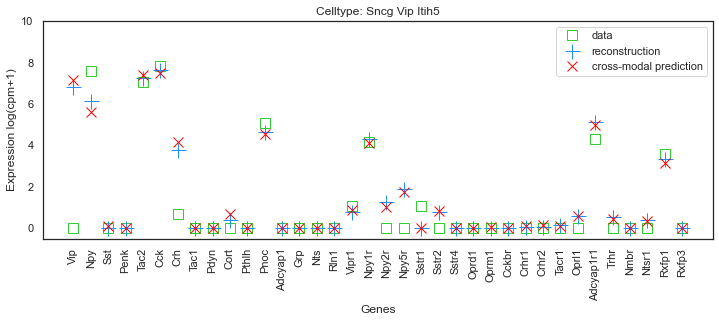

In [14]:
xticks = np.arange(gene_ind.size)

plt.figure(figsize=(12,4))
plt.plot(xticks,XT[cell_ind,gene_ind],'s',ms=10,color='limegreen',markerfacecolor='None',label='data')
plt.plot(xticks,XrT[cell_ind,gene_ind],'+',ms=15,color='dodgerblue',label='reconstruction')
plt.plot(xticks,XrT_cm[cell_ind,gene_ind],'x',ms=10,color='red',label='cross-modal prediction')

plt.legend()

ax = plt.gca()
ax.set_title('Celltype: {}'.format(D['cluster'][cell_ind]))
ax.set_ylim(-0.5,10)
ax.set_ylabel('Expression log(cpm+1)')
ax.set_xticks(xticks)
ax.set_xticklabels(D['gene_id'][gene_ind],rotation=90)
ax.set_xlabel('Genes')
plt.show()

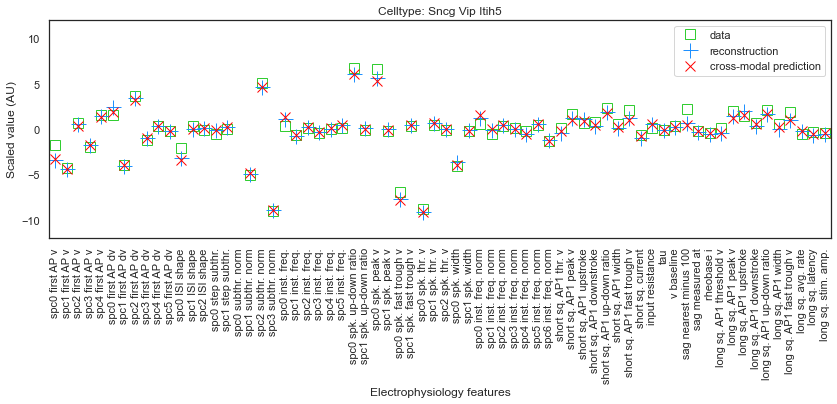

In [15]:
xticks = np.arange(feat_ind.size)

plt.figure(figsize=(14,4))
plt.plot(xticks,XE[cell_ind,feat_ind],'s',ms=10,color='limegreen',markerfacecolor='None',label='data')
plt.plot(xticks,XrE[cell_ind,feat_ind],'+',ms=15,color='dodgerblue',label='reconstruction')
plt.plot(xticks,XrE_cm[cell_ind,feat_ind],'x',ms=10,color='red',label='cross-modal prediction')

plt.legend()

ax = plt.gca()
ax.set_title('Celltype: {}'.format(D['cluster'][cell_ind]))
ax.set_ylim(-12,12)
ax.set_ylabel('Scaled value (AU)')
ax.set_xlim(xticks[0]-0.5,xticks[-1]+0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(D['pcipfx_names'][feat_ind],rotation=90)
ax.set_xlabel('Electrophysiology features')
plt.show()

In [18]:
ErE = []
TrT = []
ErE_cm = []
TrT_cm = []
for i in range(0,3411): 
    ErE_cor = np.corrcoef(XE[i,:],XrE[i,:])  
    TrT_cor = np.corrcoef(XT[i,:],XrT[i,:])
    ErE_cm_cor = np.corrcoef(XE[i,:],XrE_cm[i,:]) 
    TrT_cm_cor = np.corrcoef(XT[i,:],XrT_cm[i,:])  
    ErE.append(ErE_cor[0,1])
    TrT.append(TrT_cor[0,1])
    ErE_cm.append(ErE_cm_cor[0,1])
    TrT_cm.append(TrT_cm_cor[0,1])
print(sum(ErE) / len(ErE))
print(sum(TrT) / len(TrT))
print(sum(ErE_cm) / len(ErE_cm))
print(sum(TrT_cm) / len(TrT_cm))
    


0.9890126615801392
0.8098321356437816
0.9859963073567307
0.7829647676060779
